Running the following on BigQuerry:
```
"""
SELECT DAYOFYEAR(timestamp) as day,
       COUNT(DAYOFYEAR(timestamp)) as total_downloads,
       REGEXP_EXTRACT(details.python, r'^(\d+)') as details_python,
       REGEXP_EXTRACT(details.installer.version, r'^(\d+)') as iv,
       REGEXP_EXTRACT(file.version, r'^(\d+.\d+).\d+$') as version, 

       file.project
FROM (TABLE_DATE_RANGE([the-psf:pypi.downloads], 
                TIMESTAMP('2017-04-10'), 
                TIMESTAMP('2017-07-15')))
WHERE file.project IN ('ipython')
AND REGEXP_EXTRACT(file.version, r'^(\d+).\d+.\d+$') in ('6', '5')
AND details.installer.name == 'pip'
GROUP BY day, details_python,iv, details.installer.name, file.project, version
ORDER BY day
"""
```

In [1]:
import pandas as pd
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from IPython.display import display
plt.ion()
figsize(12,6)

In [2]:
#df = pd.read_csv('/Users/bussonniermatthias/Downloads/ipython-download-until-july-14-by-pip-and-pythons-with-minor.csv')
df = pd.read_csv('/Users/bussonniermatthias/Downloads/results-20170730-145938.csv')
df['details_python'] = df['details_python'].fillna(0.0).astype(int)
df['old_pip'] = (df['iv'] <= 8)
df = df.drop(['iv','file_project'], 1)
df['pip']= '?'
df['pip'][df['old_pip']] = 'old pip'
df['pip'][df['old_pip'] == False] = 'new pip'
df = df.drop('old_pip', 1)

/Users/bussonniermatthias/dev/ipykernel/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/bussonniermatthias/dev/ipykernel/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
df = df[df['details_python'] != 0]
df['python_version'] = df['details_python']
df = df.drop('details_python',1)
df['major_version'] = df['version'].apply(int)

In [4]:
df.head()

,day,total_downloads,version,pip,python_version,major_version
0,100,1,5.0,old pip,3,5
1,100,726,5.1,new pip,3,5
2,100,43,5.1,old pip,2,5
3,100,165,5.2,new pip,2,5
4,100,351,5.3,old pip,3,5


Let's look at the total download across versions, we'll see that "old versions" are not that much donloaded and (for now) we can drop them out of our analysis.

In [5]:
df.drop(['day', 'pip','python_version'], 1).groupby('version').max().sort_values('total_downloads')

,total_downloads,major_version
version,,
5.2,602,5
5.0,1216,5
5.1,4328,5
5.4,10818,5
5.3,10826,5
6.1,12474,6
6.0,18357,6


Let's look at the dowload depending on Day OF week"

(0, 1.0183302204727287)

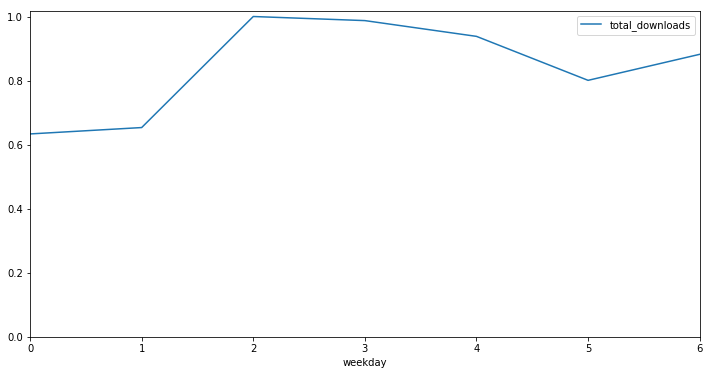

In [6]:
adj = df.drop(['version', 'python_version', 'major_version','pip'],1)
adj['weekday'] = adj['day'] % 7 
adj = adj.drop('day',1)
adj = adj.sort_values('total_downloads')[:-50]
adjdf = (adj.groupby('weekday').sum()/adj.groupby('weekday').sum().max())
ax = adjdf.plot()
ax.set_ylim(ymin=0)

We'll use that to adjust the download count and have less of a jigsaw effect on graphs. 

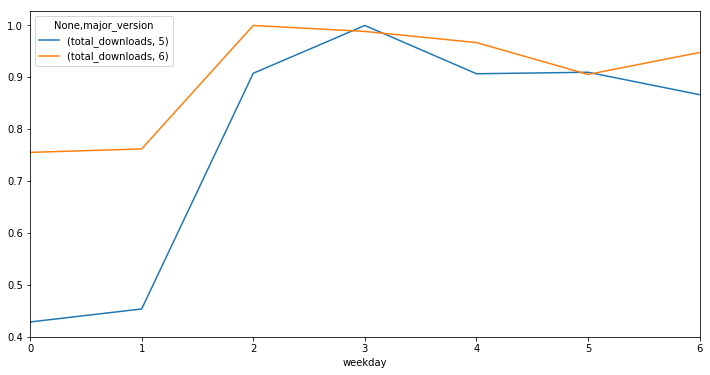

In [63]:
adj = df.drop(['version', 'python_version','pip'],1)
adj['weekday'] = adj['day'] % 7 
adj = adj.drop('day',1)
adj = adj.sort_values('total_downloads')[:-20]
adp = adj.pivot_table(adj,  index=['weekday'], columns=['major_version'], aggfunc=sum)
(adp/adp.max()).plot()

In [64]:
pp = (adp/adp.max())

pp[('total_downloads', 6)][0]

0.75517495322638428

In [65]:
def adjust_row(row):
    dow = row['day'] % 7
    row['total_downloads'] = row['total_downloads'] / adjd[dow]
    return row

In [66]:
adjd = adjdf.to_dict()['total_downloads']
def adjust_row_per_python(row):
    dow = row['day'] % 7
    row['total_downloads'] = row['total_downloads'] / pp[('total_downloads', row['major_version'])][dow]
    return row
    

In [121]:
def annotate(ax):
    ax.axvline(109, color='222', linestyle='--', lw=1)
    ax.axvline(151, color='222', linestyle='--', lw=1)
    ax.axvline(131, color='111', linestyle='-.', lw=0.5)

In [87]:
adf =  df.apply(adjust_row_per_python, 1)

In [88]:
df.drop(['day', 'pip','python_version'], 1).groupby('version').sum().sort_values('total_downloads')
original_df = df
original_df.head()

,day,total_downloads,version,pip,python_version,major_version
0,100,1,5.0,old pip,3,5
1,100,726,5.1,new pip,3,5
2,100,43,5.1,old pip,2,5
3,100,165,5.2,new pip,2,5
4,100,351,5.3,old pip,3,5


In [89]:
# df = df.loc[df['version'].isin(('6.0','6.1', '5.3', '5.4'))]

In [90]:
# params = {'version', 'python_version', 'pip'}

# cat = 'version'
# param1,param2 = [p for p in params if p is not cat]

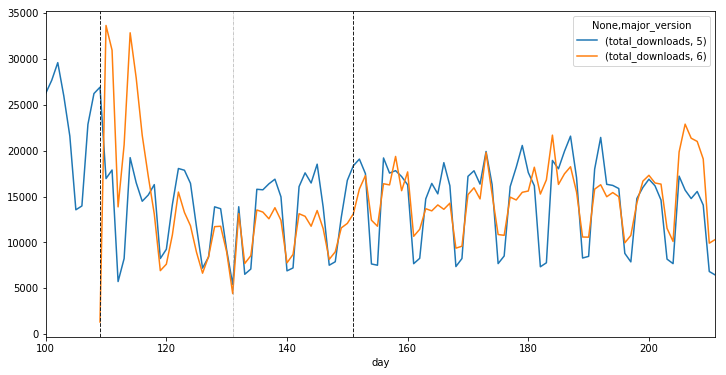

In [122]:
dff = df.drop(['pip', 'python_version',  'version'], 1)
# adjust(dff)
ax = dff.pivot_table(dff, index=['day'], columns=['major_version'], aggfunc=sum).plot()
annotate(ax)


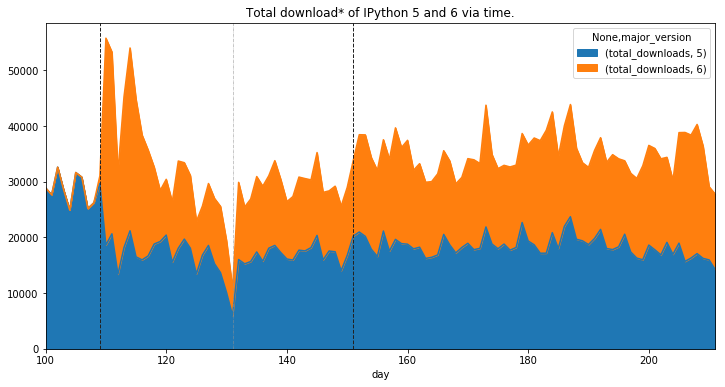

In [190]:
dff = adf.drop(['pip', 'python_version',  'version'], 1)
ax = dff.pivot_table(dff, index=['day'], columns=['major_version'], aggfunc=sum).plot(kind='area')

annotate(ax)
ax.set_title("Total download* of IPython 5 and 6 via time.")

As you can see above, the download of IPython 6, see a huge spike on the days follwing te release (with a dip in the weke-end). And stabilise at a higher rate than the IPython 5 download before the release.

The global download og

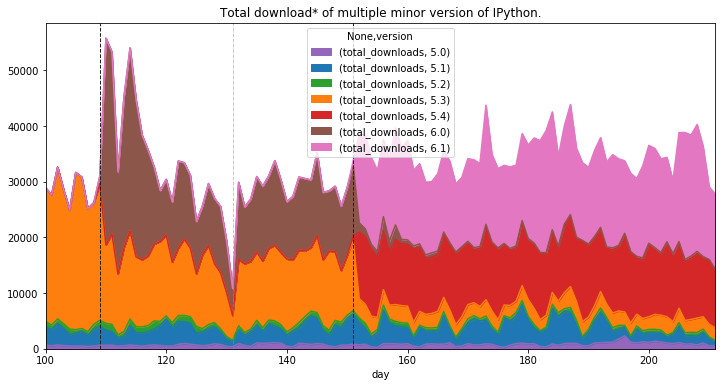

In [189]:
dfg = adf.drop(['pip', 'python_version',  'major_version'], 1)

dfg = dfg.loc[dfg['version'].isin(('5.1','5.3','5.4','6.0','6.1', '5.0', '5.2'))]
ax = dfg.pivot_table(dfg, index=['day'], columns=['version'], aggfunc=sum).plot(kind='area', color=['C4', 'C0', 'C2', 'C1','C3', 'C5','C6'])
annotate(ax)

ax.set_title("Total download* of multiple minor version of IPython.")

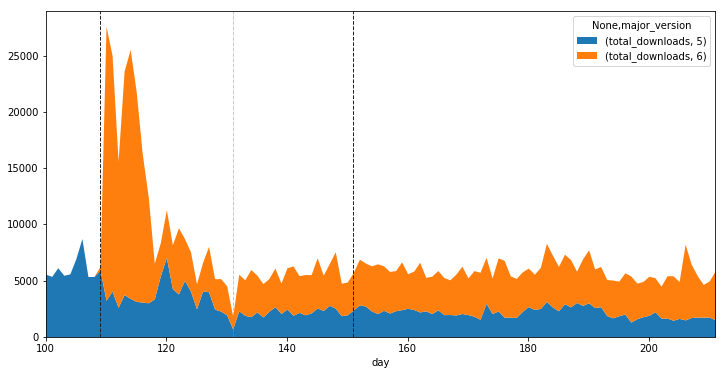

In [188]:
ldf = adf.drop('version',1)
#ldf = ldf[ldf['major_version'] == 5].drop('major_version', 1)
ldf = ldf[ldf['python_version'] == 2].drop('python_version', 1)
ldf = ldf[ldf['pip'] == 'old pip'].drop('pip', 1)

ax = ldf.pivot_table(ldf, index=['day'], columns=['major_version'], aggfunc=sum).plot(kind='area', lw=0)
annotate(ax)

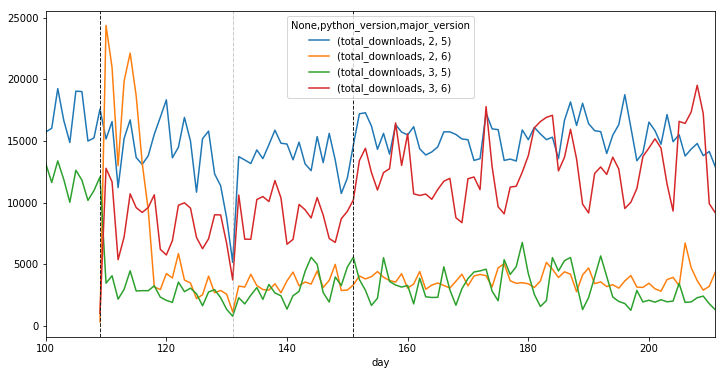

In [184]:
ldf = adf.drop('version',1)
#ldf['day'] = ldf['day'] // 7
# ldf = ldf[ldf['major_version'] == 6].drop('major_version', 1)
# ldf = ldf[ldf['python_version'] == 2].drop('python_version', 1)
# ldf = ldf[ldf['pip'] == 'old pip'].drop('pip', 1)

ax = ldf.pivot_table(ldf, index=['day'], columns=['python_version', 'major_version'], aggfunc=sum).plot()#.bar(stacked=True, width=1.0)
annotate(ax)

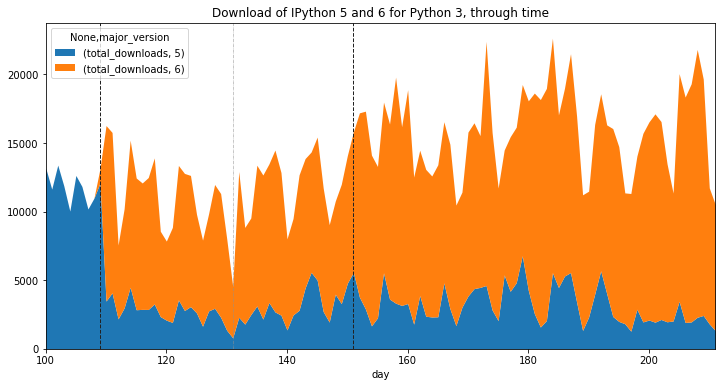

In [182]:
ldf = adf.drop('version',1)
# ldf = ldf[ldf['major_version'] == 6].drop('major_version', 1)
ldf = ldf[ldf['python_version'] == 3].drop('python_version', 1)
# ldf = ldf[ldf['pip'] == 'old pip'].drop('pip', 1)

ax = ldf.pivot_table(ldf, index=['day'], columns=['major_version'], aggfunc=sum).plot(kind='area',lw=0)#.bar(stacked=True, width=1.0)
annotate(ax)
ax.set_title('Download of IPython 5 and 6 for Python 3, through time')

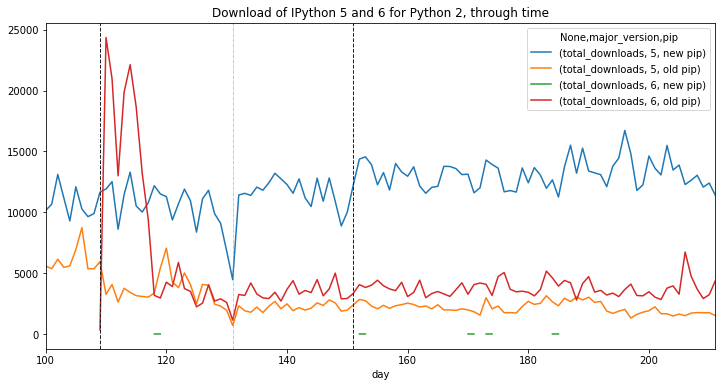

In [180]:
ldf = adf.drop('version',1)
# ldf = ldf[ldf['major_version'] == 6].drop('major_version', 1)
ldf = ldf[ldf['python_version'] == 2].drop('python_version', 1)
# ldf = ldf[ldf['pip'] == 'old pip'].drop('pip', 1)
ax = ldf.pivot_table(ldf, index=['day'], columns=['major_version', 'pip'], aggfunc=sum).plot()#.bar(stacked=True, width=1.0)
annotate(ax)
ax.set_title("Total download of IPython (v5/v6) for Python 2 users.")
ax.set_title('Download of IPython 5 and 6 for Python 2, through time')

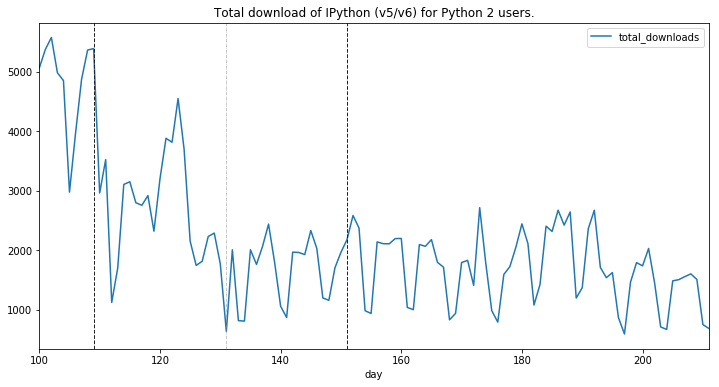

In [131]:
ldf = df.drop('version',1)
ldf = ldf[ldf['major_version'] == 5].drop('major_version', 1)
ldf = ldf[ldf['python_version'] == 2].drop('python_version', 1)
ldf = ldf[ldf['pip'] == 'old pip'].drop('pip', 1)
ax = ldf.pivot_table(ldf, index=['day'], columns=[], aggfunc=sum).plot()#.bar(stacked=True, width=1.0)
annotate(ax)
ax.set_title("Total download of IPython (v5/v6) for Python 2 users.")

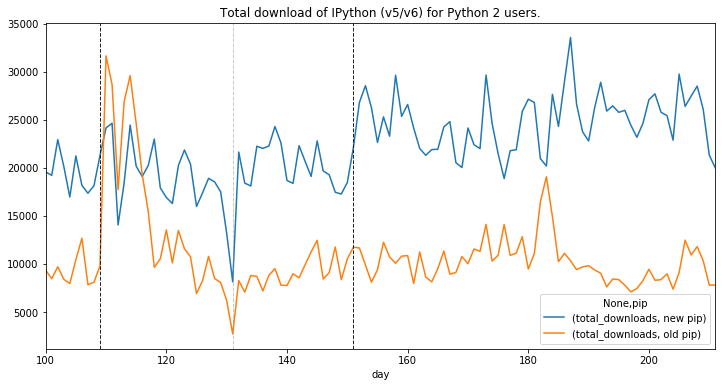

In [142]:
ldf = adf.drop(['version','major_version', 'python_version'],1)
#ldf = ldf[ldf['major_version'] == 5].drop('major_version', 1)
#ldf = ldf[ldf['python_version'] == 2].drop('python_version', 1)
#ldf = ldf[ldf['pip'] == 'old pip'].drop('pip', 1)
ldf = ldf.pivot_table(ldf, index=['day'], columns=['pip'], aggfunc=sum)
ax = ldf.plot()
annotate(ax)
ax.set_title("Total download of IPython (v5/v6) for Python 2 users.")

In [157]:
ldf['sum'] = ldf.sum(axis=1)

In [165]:
ldf[('total_downloads','new pip')] = ldf[('total_downloads','new pip')] / ldf['sum']

In [167]:
ldf[('total_downloads','old pip')] = ldf[('total_downloads','old pip')] / ldf['sum']

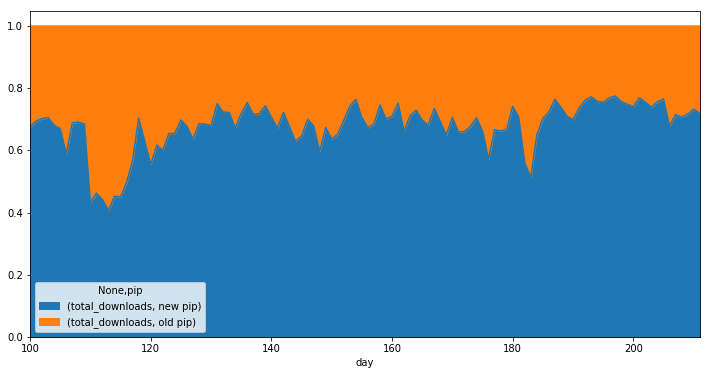

In [174]:
ldf.drop('sum', 1).plot(kind='area', stacked=True)

In [ ]:
for p1 in set([p for p in df[param1] if not pd.isnull(p)]):
    for p2 in set([p for p in df[param2] if not pd.isnull(p)]):
        dff = (df
                 .where(df[param1] == p1)
                 .where(df[param2] == p2)
                 #.drop(param1,1)
                 #.drop(param2,1)
                 #     .dropna(how='all')
                  .pivot_table(df,
                  index=['day'],
                       columns=[p for p in params if p not in [param1, param2]],
                  )
        )
        dff.plot()
        plt.title(f'{param1}={p1}          {param2}={p2}')
        plt.xlim(100)
        plt.axvline(110, linestyle='--', color='k', alpha=0.5)

In [ ]:
pldf = (df.where(df['file_project'] == 'ipython')
                      #.where(df['version'] == version)
                      .where(df['details_python'] != 0)
                      .drop('version',1)
                      #.where(df['old_pip']==old_pip)
                      #.drop('iv', 1)
                      .dropna(how='all')
                      .pivot_table(df_to_plot_ipython5,
                            index=['day',],
                            columns=['details_python', 'old_pip'],
                      )
)
pldf.plot(subplots=True)
pipv = 'pip < 9' if old_pip else 'pip 9+'
plt.title(f'download of IPython {version} with {pipv}')
plt.xlim(100)
plt.axvline(110, linestyle='--', color='k', alpha=0.5)

In [ ]:
pldf.plot(subplots=True)

In [ ]:
ipython5_pivot = pd.pivot_table(df_to_plot_ipython5,
                    index=['day'],
                    columns=['details_python', 'old_pip'],
)
display(ipython5_pivot.head())
ipython5_pivot.where(df['old_pip']==False).plot()

In [ ]:
df_to_plot_ipython6 = (df
                       .where(df['file_project'] == 'ipython')
                       .where((df['iv'] > 7))
                       .where(df['version'] == 6)
                       .where(((df['iv']==8)&(df['details_python']==2))|
                              ((df['iv']==9)&(df['details_python']==3)))
                       .drop('version',1)
                       .dropna(how='all')
                      )
df_to_plot_ipython6['iv'] = df_to_plot_ipython6['iv'].astype(int)
df_to_plot_ipython6['details_python'] = df_to_plot_ipython6['details_python'].astype(int)

ipython6_pivot = pd.pivot_table(df_to_plot_ipython6, 
                                index=['day'], 
                                columns=['details_python', 'iv']) 

# Plotting

In [ ]:
release_day = 110
global_ylim = 19900
ylabel_dict = {
    'ylabel': 'Total Downloads',
    'fontsize': 'large'
}

xlabel_dict = {
    'xlabel': 'Days',
    'fontsize': 'large'
}


title_template = "Downloads of IPython {}"
legend_format = {
    "frameon": False,
    "fontsize": 'large'
}
release_day_line_format = {
    "linestyle": '--',
    "color": 'k',
    "alpha": 0.5
}
title_format = {
    'fontdict':{
        'fontsize': 'x-large',
    }
}



In [ ]:
fig_ipython5, ipython5_ax = plt.subplots()
ipython5_pivot.plot(title=title_template.format(5),
                    ax=ipython5_ax,
                    color=['c','orange']
                    )
ipython5_ax.set_title(ipython5_ax.get_title(), **title_format)   # what do you mean multiline edit ?
ipython5_ax.axvline(release_day, **release_day_line_format)   # what do you mean multiline edit ?
ipython5_ax.spines['right'].set_visible(False)   # what do you mean multiline edit ?
ipython5_ax.spines['top'].set_visible(False)
ipython5_ax.set_ylim(0,global_ylim)   # what do you mean multiline edit ?
ipython5_ax.set_ylabel(**ylabel_dict)   # what do you mean multiline edit ?
ipython5_ax.set_xlabel(**xlabel_dict)   # what do you mean multiline edit ?
ipython5_ax.legend(labels=['Py2, pip 9','Py3, pip 9'], **legend_format)

fig_ipython5.savefig('ipython5_dl.png', bbox_inches='tight')

Download of IPython 5 - 9, on Python 2 and Python 3. We see the 2 lower curves are the downloads of IPython 5 using pip 8 both on Python 2 and Python 3. At day 110 we see a clear decrease in pip 8  download.

It make sense for python 2 - pip install with pip 8 breaks, and ask users to upgrade. 
The Python 3 is more surprising. – this is likely due to the blog post annouce that explicitely warn to update pip before upgrading IPython. 

User do listen :-) even user on IPython 5. 

The red curve show a sharp decrease of IPython 5 download with pip-9 on Python 3. These are users upgrading to IPython 6. 

The red curve noise level are explicit installs, and pinned versions I guess.

The Orange Curve is the sustained install of IPython 5 for pip-9 users, these will likely not even realize we did release a new version. 

So far:  Mission accomplished.

In [ ]:
fig_ipython6, ipython6_ax = plt.subplots()
ipython6_pivot.plot(title=title_template.format(6), color=['C0','orange'], ax = ipython6_ax)

ipython6_ax.set_title(ipython6_ax.get_title(), **title_format)
ipython6_ax.axvline(release_day, linestyle='--', color='k', alpha=0.5)
ipython6_ax.spines['right'].set_visible(False)
ipython6_ax.spines['top'].set_visible(False)
ipython6_ax.set_ylabel(**ylabel_dict)
ipython6_ax.set_xlabel(**xlabel_dict)
ipython6_ax.set_xlim(100);
ipython6_ax.set_ylim(0,global_ylim)
ipython6_ax.legend(labels=['Py2, pip 8','Py3, pip 9'], **legend_format)

fig_ipython6.savefig('ipython6_dl.png', bbox_inches='tight')

The orange curve is the sustained download of IPython 6 with pip 9 on Python 3. 

The blue curve are the – appology to them – Python 2 users with pip 8, for which the installation fails, and get presented with a nice error message asking to upgrade pip. 
These have either upgraded pip to pip 9, or pinned ipython's version. 

If they updated pip you should (?) see an increase of download in IPython 5.x – though we have no new release, maybe we should have released 5.4 at the same time ?

In [ ]:
figsize(10,6)

In [ ]:
fig, (ipython5_ax, ipython6_ax) = plt.subplots(2, 1, sharex=True)


# set all the ipython5 bits

ipython5_pivot.plot(title=title_template.format(5), color=['c','orange'], ax=ipython5_ax)

ipython5_ax.set_title(ipython5_ax.get_title(), **title_format)
ipython5_ax.axvline(release_day, linestyle='--', color='k', alpha=0.5)
ipython5_ax.spines['right'].set_visible(False)
ipython5_ax.spines['top'].set_visible(False)
ipython5_ax.set_ylim(0,global_ylim)
ipython5_ax.set_ylabel(**ylabel_dict)
ipython5_ax.set_xlabel(**xlabel_dict)
ipython5_ax.legend(labels=['Py2, pip 9','Py3, pip 9'], **legend_format)

# set all the ipython6 bits
ipython6_pivot.plot(title=title_template.format(6), color=['C0','orange'], ax = ipython6_ax)

ipython6_ax.set_title(ipython6_ax.get_title(), **title_format)
ipython6_ax.axvline(release_day, linestyle='--', color='k', alpha=0.5)
ipython6_ax.spines['right'].set_visible(False)
ipython6_ax.spines['top'].set_visible(False)
ipython6_ax.set_ylabel(**ylabel_dict)
ipython6_ax.set_xlabel(**xlabel_dict)
ipython6_ax.set_xlim(100);
ipython6_ax.set_ylim(0,global_ylim)
ipython6_ax.legend(labels=['Py2, pip 8','Py3, pip 9'], **legend_format)

# saving figure
fig.savefig('combined_ipython_graphs.png', bbox_inches='tight')